## Mapping PQs

In [43]:
import pandas as pd
import requests
import json
import geojson
import geopandas as gpd
from matplotlib import pyplot as plt

Steps involved are:
1. Import constituency data
2. Import constiteuncy boundaries
3. Match boundaries and Parliamentary constituency data
4. Import and match PQs data. 

In [2]:
# Import constituency data

In [97]:
cdf = pd.read_csv('tmp/active_constituencies.csv')

In [98]:
cdf.head()

,id,name,startDate,endDate,currentRepresentationmembervalueid,currentRepresentationmembervaluenameListAs,currentRepresentationmembervaluenameDisplayAs,currentRepresentationmembervaluenameFullTitle,currentRepresentationmembervaluenameAddressAs,currentRepresentationmembervaluelatestPartyid,...,currentRepresentationmemberlinks,currentRepresentationrepresentationmembershipFrom,currentRepresentationrepresentationmembershipFromId,currentRepresentationrepresentationhouse,currentRepresentationrepresentationmembershipStartDate,currentRepresentationrepresentationmembershipEndDate,currentRepresentationrepresentationmembershipEndReason,currentRepresentationrepresentationmembershipEndReasonNotes,currentRepresentationrepresentationmembershipEndReasonId,currentRepresentationrepresentationmembershipStatus
0,3847,West Tyrone,2010-05-06T00:00:00,NaN,4697,"Begley, Órfhlaith",Órfhlaith Begley,Órfhlaith Begley MP,NaN,30,...,"[{'rel': 'self', 'href': '/Members/4697', 'met...",West Tyrone,3847,1,2018-05-03T00:00:00,NaN,NaN,NaN,NaN,NaN
1,3664,Nottingham East,2010-05-06T00:00:00,NaN,4869,"Whittome, Nadia",Nadia Whittome,Nadia Whittome MP,NaN,15,...,"[{'rel': 'self', 'href': '/Members/4869', 'met...",Nottingham East,3664,1,2019-12-12T00:00:00,NaN,NaN,NaN,NaN,NaN
2,110,Banff and Buchan,2005-04-05T00:00:00,NaN,4606,"Duguid, David",David Duguid,David Duguid MP,David Duguid,4,...,"[{'rel': 'self', 'href': '/Members/4606', 'met...",Banff and Buchan,110,1,2017-06-08T00:00:00,NaN,NaN,NaN,NaN,NaN
3,3383,Calder Valley,2010-05-06T00:00:00,NaN,3940,"Whittaker, Craig",Craig Whittaker,Craig Whittaker MP,Craig Whittaker,4,...,"[{'rel': 'self', 'href': '/Members/3940', 'met...",Calder Valley,3383,1,2010-05-06T00:00:00,NaN,NaN,NaN,NaN,NaN
4,3513,Hampstead and Kilburn,2010-05-06T00:00:00,NaN,4518,"Siddiq, Tulip",Tulip Siddiq,Tulip Siddiq MP,Tulip Siddiq,15,...,"[{'rel': 'self', 'href': '/Members/4518', 'met...",Hampstead and Kilburn,3513,1,2015-05-07T00:00:00,NaN,NaN,NaN,NaN,NaN


In [100]:
# Import boundaries
cgdf = gpd.read_file('tmp/pcon_boundaries.geojson')
# There's a slight discrepancy in the name of constituencies - the ONS dataset capitalises the 'S' in Weston-super-Mare. 
cgdf['PCON20NM'] = cgdf.PCON20NM.apply(lambda x: x.replace('Weston-Super-Mare', 'Weston-super-Mare'))

<AxesSubplot:>

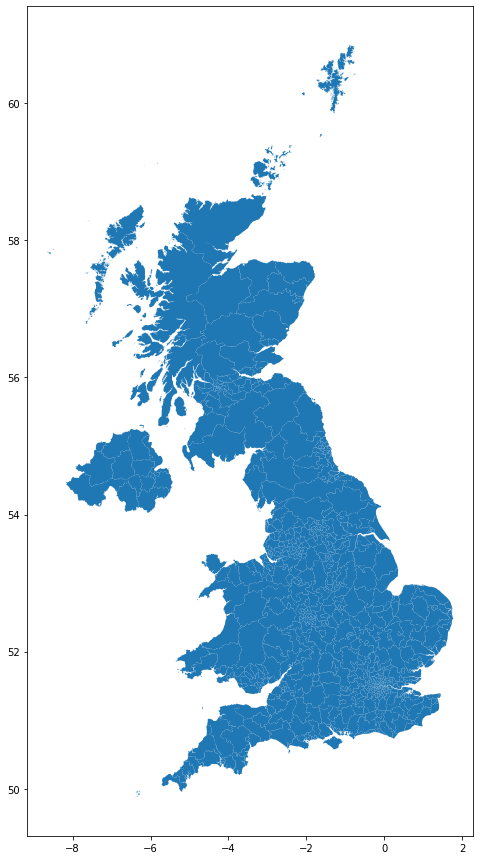

In [101]:
cgdf.plot(figsize=(8, 18))

In [102]:
cdf = cdf[['id', 'name', 'currentRepresentationmembervalueid', 'currentRepresentationmembervaluelatestPartyabbreviation', 'currentRepresentationmembervaluenameListAs']]

In [103]:
cgdf = cgdf.merge(cdf, how='left', left_on='PCON20NM', right_on='name')

In [112]:
cgdf.columns

Index(['OBJECTID', 'PCON20CD', 'PCON20NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'SHAPE_Length', 'SHAPE_Area', 'geometry', 'id', 'name',
       'currentRepresentationmembervalueid',
       'currentRepresentationmembervaluelatestPartyabbreviation',
       'currentRepresentationmembervaluenameListAs'],
      dtype='object')

Import PQs data and groupby MP so that we can start to make some plots. 

In [120]:
wpqs = pd.read_csv('cleaned.csv')
wpqs['cleanedQuestion'].fillna('', inplace=True)
wpqs['topic'].fillna('', inplace=True)
wpqs['dateTabled'] = pd.to_datetime(wpqs.dateTabled)

# Optionally select only PQs tabled since the beginning of this Parliament

wpqs = wpqs[wpqs.dateTabled > '2019-12-15']

In [121]:
# Let's start by creating a map of the number of PQs tabled from the MP in each constituency. 

wpqs_mp_total = wpqs.groupby('askingMemberId').count()[['id']].reset_index().rename(columns={'id':'totalPQs'})

In [122]:
wpqs_mp_total.head()

,askingMemberId,totalPQs
0,8,5
1,14,239
2,18,135
3,33,9
4,40,6


In [123]:
mp_total_gdf = cgdf.merge(wpqs_mp_total, how='left', left_on='currentRepresentationmembervalueid', right_on='askingMemberId')

In [124]:
mp_total_gdf[['currentRepresentationmembervaluenameListAs', 'totalPQs']].sort_values('totalPQs', ascending=False).head(20)

,currentRepresentationmembervaluenameListAs,totalPQs
531,"Maskell, Rachael",3227.0
400,"Dhesi, Mr Tanmanjeet Singh",1562.0
234,"Thornberry, Emily",1528.0
301,"Onwurah, Chi",1498.0
548,"Shannon, Jim",1480.0
310,"Jones, Mr Kevan",1395.0
68,"Lucas, Caroline",1375.0
502,"Brown, Ms Lyn",1335.0
370,"Rosindell, Andrew",1318.0
625,"Jones, Ruth",1217.0


<AxesSubplot:>

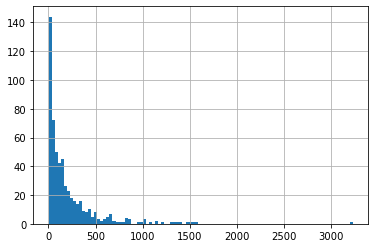

In [125]:
mp_total_gdf.totalPQs.hist(bins=100)

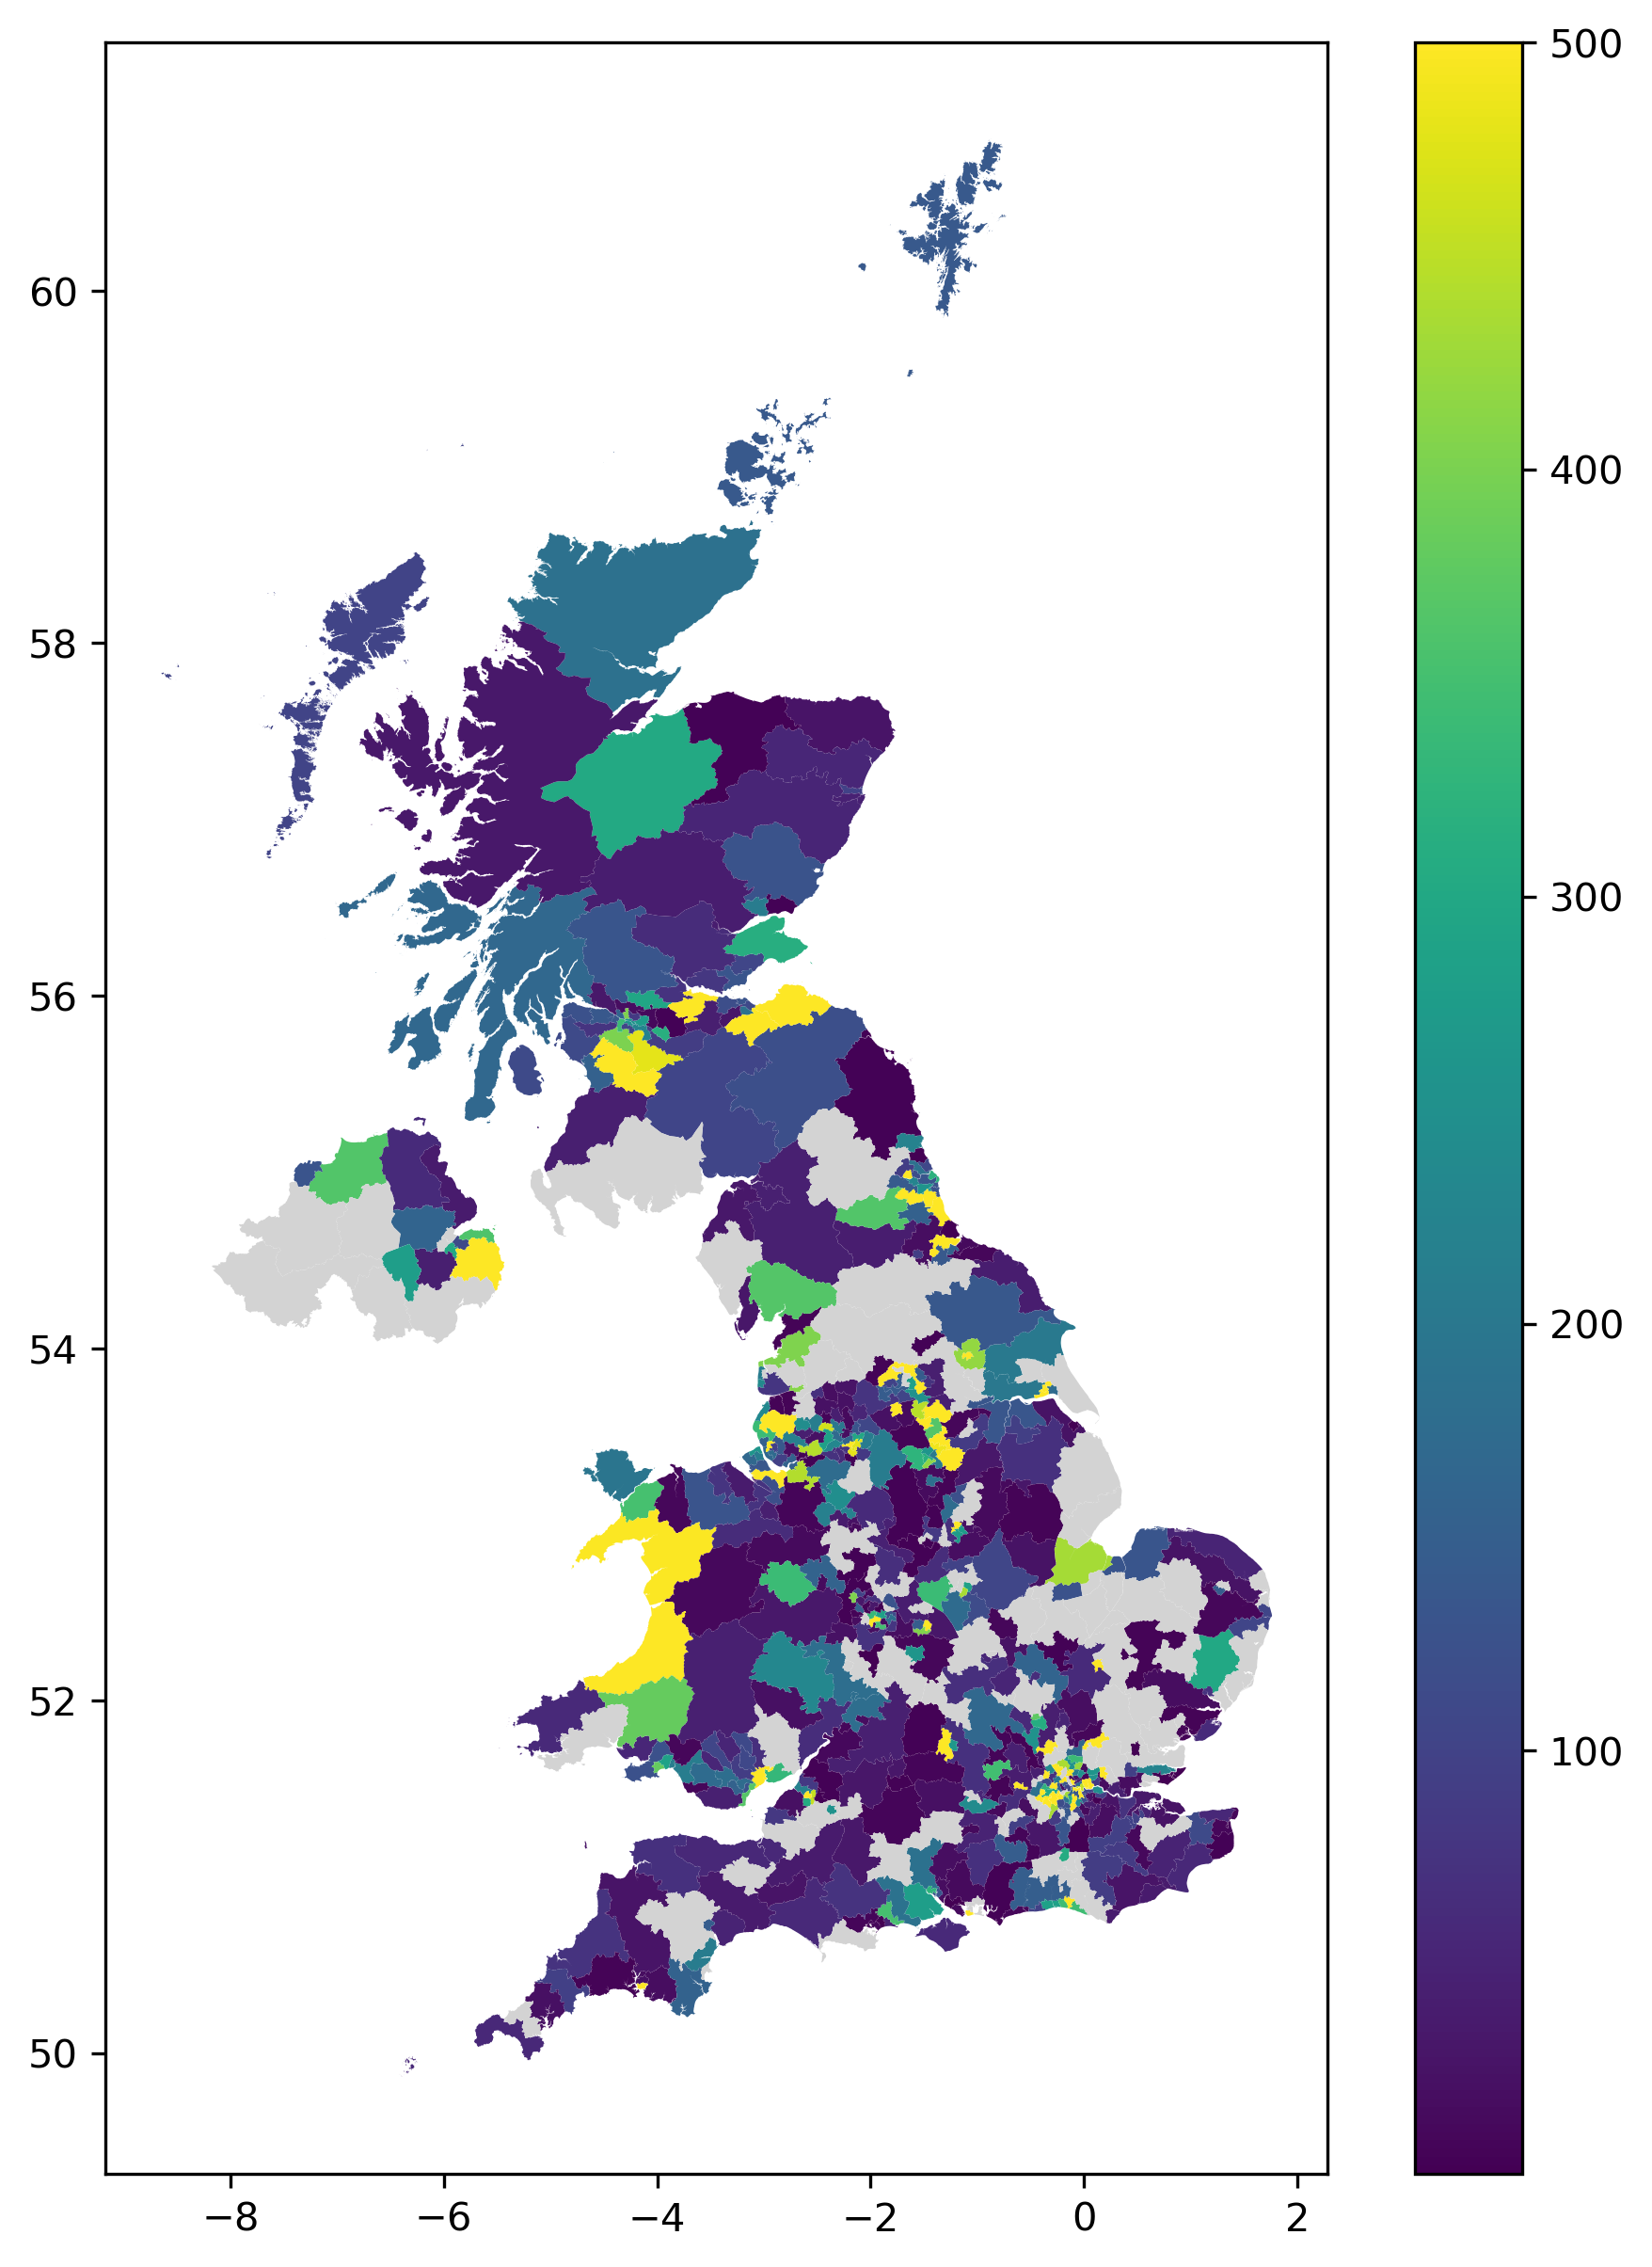

In [134]:
# Let's map it

fig, ax = plt.subplots(figsize=(8, 10), dpi=300)

mp_total_gdf.plot(column='totalPQs', ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, vmax=500)

plt.show()

In [133]:
mp_total_gdf[mp_total_gdf.totalPQs.isna()].currentRepresentationmembervaluenameListAs.tolist()

['Docherty, Leo',
 'Morton, Wendy',
 'Prentis, Victoria',
 'Stuart, Graham',
 'Hamilton, Paulette',
 'Warman, Matt',
 'Cleverly, James',
 'Burghart, Alex',
 'Churchill, Jo',
 'Eustice, George',
 'Milling, Amanda',
 'Harris, Rebecca',
 'Stride, Mel',
 'Argar, Edward',
 'Hands, Greg',
 'Donelan, Michelle',
 'Hoyle, Sir Lindsay',
 'Quince, Will',
 'Harrison, Trudy',
 'Pursglove, Tom',
 'Philp, Chris',
 'Heaton-Harris, Chris',
 'Solloway, Amanda',
 'Winterton, Dame Rosie',
 'Laing, Dame Eleanor',
 'Throup, Maggie',
 'Raab, Dominic',
 'Whately, Helen',
 'Freer, Mike',
 'Lewis, Brandon',
 'Morris, James',
 'Mak, Alan',
 'Dowden, Oliver',
 'Opperman, Guy',
 'Starmer, Keir',
 'Lopez, Julia',
 'Quin, Jeremy',
 'Kendall, Liz',
 'Caulfield, Maria',
 'Atkins, Victoria',
 'Rutley, David',
 'Whittingdale, Mr John',
 'Dorries, Ms Nadine',
 'Freeman, George',
 'Davies, Mims',
 'Huddleston, Nigel',
 'Stewart, Iain',
 'Barclay, Steve',
 'Rees-Mogg, Mr Jacob',
 'Vara, Shailesh',
 'Malthouse, Kit',
 'Elli